# GEO-AI Challenge for Cropland Mapping by ITU
This is a notebook to describe my processes that I have used to perform analysis and come up with my model for the Zindi competition on [Cropland Mapping](https://zindi.africa/competitions/geo-ai-challenge-for-cropland-mapping-with-satellite-imagery) by ITU.
This analysis involves acquisition of data from Google Earth Engine as it is the most efficient method to get the scale of data without exhausintg the resources of my local machine. The data is then processed and exported to my local machine for further analysis and model building.

The notebook is divided into the following sections:
1. [Data Acquisition](#data-acquisition)
2. [Data Preprocessing](#data-preprocessing)
3. [Model Building](#model-building)
4. [Model Evaluation](#model-evaluation)
5. [Submission](#submission)

## SETUP
### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import ee
import concurrent.futures as cf
import geemap

sns.set_style('whitegrid')
sns.set_palette('Set2')

### Initial Train and Test Data

In [2]:
train_data = pd.read_csv('data/Train.csv', index_col='ID')
test_data = pd.read_csv('data/Test.csv', index_col='ID')

whole_data = pd.concat([train_data.drop(columns=['Target']), test_data], axis=0)
target = train_data['Target']

### Earth Engine Authentication

In [3]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


## <a class="anchor" id="data-acquisition">DATA ACQUISITION</a>
The nature of Google Earth Engine is such that to get data, the api has to make a request to the server and the server returns the data. This means that the data is not stored locally and has to be downloaded from the server. This is a very slow process and can take a lot of time. While I have tried to make the process as efficient as possible, it still takes a lot of time to get the data. I have tried to make the process as efficient as possible.

### National Boundaries
The study forcuses on the following countries:
1. Iran (Islamic Republic of)
2. Sudan
3. Afghanistan

Since the data is not very specific or the regions of interest big enough to warrant the level of detail that will be produced by any method of boundary data acquisition. As such I have decided to get the general bounds of each data-set by using Latitude and Longitude values of the corners of the data-set. Then adding a buffer on each region. 

First, plotting the points on a map to get a visual representation of the data.


In [4]:
Map = geemap.Map()
points = ee.Geometry.MultiPoint(whole_data[['Lon', 'Lat']].values.tolist())
Map.addLayer(points, {}, 'points')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Toggl…

<Axes: xlabel='Lon', ylabel='Lat'>

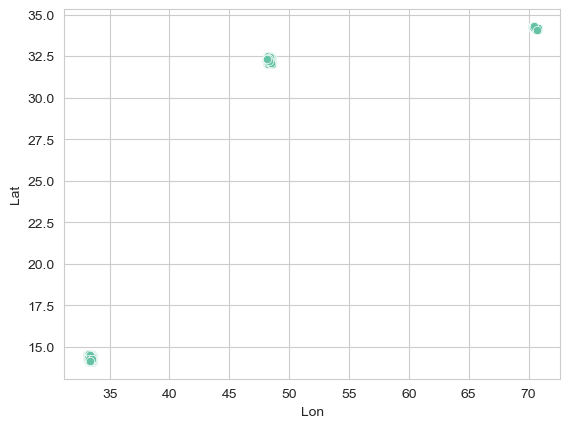

In [5]:
sns.scatterplot(x='Lon', y='Lat', data=whole_data)

In [6]:
sudan_extents = [30,12.5,38.5,15.0]
iran_extents = [45,30,50,35]
afghanistan_extents = [65, 32.5, 75, 35]

<Axes: xlabel='Lon', ylabel='Lat'>

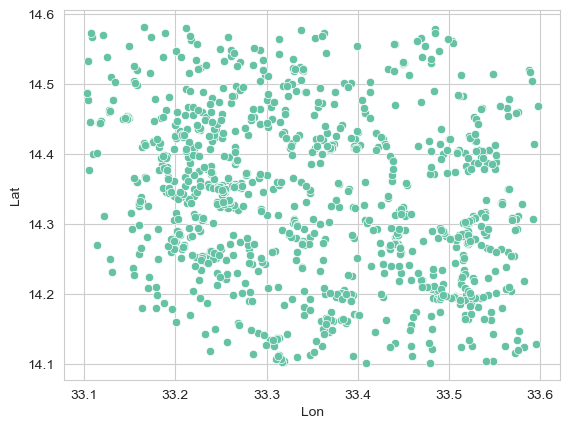

In [7]:
sudan_points = whole_data[
  (whole_data['Lon'] > sudan_extents[0]) & 
  (whole_data['Lon'] < sudan_extents[2]) & 
  (whole_data['Lat'] > sudan_extents[1]) & 
  (whole_data['Lat'] < sudan_extents[3])
  ]
sns.scatterplot(x='Lon', y='Lat', data=sudan_points)

<Axes: xlabel='Lon', ylabel='Lat'>

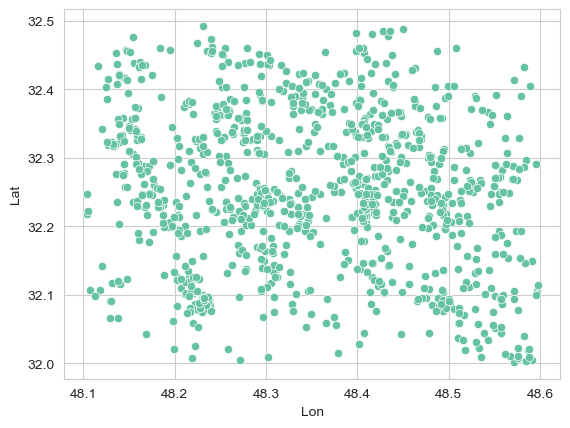

In [8]:
iran_points = whole_data[
  (whole_data['Lon'] > iran_extents[0]) & 
  (whole_data['Lon'] < iran_extents[2]) & 
  (whole_data['Lat'] > iran_extents[1]) & 
  (whole_data['Lat'] < iran_extents[3])
  ]
sns.scatterplot(x='Lon', y='Lat', data=iran_points)

<Axes: xlabel='Lon', ylabel='Lat'>

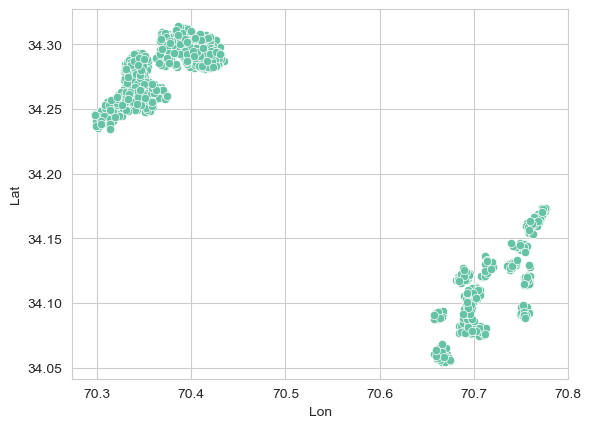

In [9]:
afghanistan_points = whole_data[
  (whole_data['Lon'] > afghanistan_extents[0]) & 
  (whole_data['Lon'] < afghanistan_extents[2]) & 
  (whole_data['Lat'] > afghanistan_extents[1]) & 
  (whole_data['Lat'] < afghanistan_extents[3])
  ]
sns.scatterplot(x='Lon', y='Lat', data=afghanistan_points)

However much this process has been longwinded, the alternative of getting the data from Earth Engine is very tedious as each point is evaluated individually. This way we are certain of the place. Additionally, we can specify the roi geometry from this data as follows.

In [10]:
sudan_point_gdf = gpd.GeoDataFrame(sudan_points, geometry=gpd.points_from_xy(sudan_points['Lon'], sudan_points['Lat']))
iran_point_gdf = gpd.GeoDataFrame(iran_points, geometry=gpd.points_from_xy(iran_points['Lon'], iran_points['Lat']))
afghanistan_point_gdf = gpd.GeoDataFrame(afghanistan_points, geometry=gpd.points_from_xy(afghanistan_points['Lon'], afghanistan_points['Lat']))

In [11]:
sudan_roi = ee.Geometry.Rectangle(
  sudan_point_gdf.total_bounds.tolist()
).buffer(5000)
iran_roi = ee.Geometry.Rectangle(
  iran_point_gdf.total_bounds.tolist()
).buffer(5000)
afghanistan_roi = ee.Geometry.Rectangle(
  afghanistan_point_gdf.total_bounds.tolist()
).buffer(5000)

Map.addLayer(sudan_roi, {}, 'sudan_roi')
Map.addLayer(iran_roi, {}, 'iran_roi')
Map.addLayer(afghanistan_roi, {}, 'afghanistan_roi')

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Toggl…

### Image Collections
The nature of the Imagery to be used has to satisfy the following criteria:
1. The imagery has to have a ``spatial resolution of 10m`` or less.
2. For Iran and Sudan the temporal range is ``July 2019 ~ June 2020``.
3. For Afghanistan the temporal range is ``April 2022``.

In [118]:
def mask_s2_clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask).divide(10000)

def get_s2_collection(roi: ee.Geometry, start_date: str, end_date: str):
  s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                  .filterBounds(roi)
                  .filterDate(start_date, end_date)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                  .map(mask_s2_clouds))
  return s2_collection  

def get_2m_temperature_collection(roi: ee.Geometry, start_date: str, end_date: str):
  temp_collection = (ee.ImageCollection('ECMWF/ERA5/DAILY')
                  .filterBounds(roi)
                  .filterDate(start_date, end_date)
                  .select('mean_2m_air_temperature'))
  return temp_collection

def get_mean_values(collection, lat, lon):
  point = ee.Geometry.Point(lon, lat)
  mean_dict = collection.mean().reduceRegion(ee.Reducer.mean(), point, 10).getInfo()
  return mean_dict

def get_mean_image(collection):
  return collection.mean().getInfo()

In [119]:
afghanistan_roi_collection = get_s2_collection(afghanistan_roi, '2022-04-01', '2022-04-30')
sudan_roi_collection = get_s2_collection(sudan_roi, '2019-07-01', '2020-06-30')
iran_roi_collection = get_s2_collection(iran_roi, '2019-07-01', '2020-06-30')

suden_temp_collection = get_2m_temperature_collection(sudan_roi, '2019-07-01', '2020-06-30')
iran_temp_collection = get_2m_temperature_collection(iran_roi, '2019-07-01', '2020-06-30')
afghanistan_temp_collection = get_2m_temperature_collection(afghanistan_roi, '2022-04-01', '2022-04-30')

In [16]:
Map.addLayer(sudan_roi_collection.mean(), {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.3
  }, 'Sudan Collection')

Map.addLayer(iran_roi_collection.mean(), {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.3
  }, 'iran_collection')

Map.addLayer(afghanistan_roi_collection.mean(), {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.3
  }, 'afghanistan_collection')


In [18]:
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Toggl…

### Band Values
Since the analysis is for points that have already been identified, the task becomes to get band data for the points. The bands will be used to obtain the following indices:
1. NDVI - Normalized Difference Vegetation Index
2. NDWI - Normalized Difference Water Index
3. MSAVI2 - Modified Soil Adjusted Vegetation Index
4. EVI - Enhanced Vegetation Index
5. NDBI - Normalized Difference Built-up Index

To compute these indices, we need the following Sentinel-2 MSI bands:
1. B2 - Blue
2. B3 - Green
3. B4 - Red
4. B8 - NIR

However, all the other bands from B2-B12 will also be added. Getting these values however is a long process since we have to get the median values and mean values for each point individually. 


In [19]:
bands_of_interest = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']

In [20]:
with cf.ThreadPoolExecutor() as executor:
  iran_results = list(executor.map(lambda x: get_mean_values(iran_roi_collection, x[1]['Lat'], x[1]['Lon']), iran_points.iterrows()))
  afghanistan_results = list(executor.map(lambda x: get_mean_values(afghanistan_roi_collection, x[1]['Lat'], x[1]['Lon']), afghanistan_points.iterrows()))
  sudan_results = list(executor.map(lambda x: get_mean_values(sudan_roi_collection, x[1]['Lat'], x[1]['Lon']), sudan_points.iterrows()))
  
sudan_set = sudan_points.join(pd.DataFrame(sudan_results, index=sudan_points.index))
iran_set = iran_points.join(pd.DataFrame(iran_results, index=iran_points.index))
afghanistan_set = afghanistan_points.join(pd.DataFrame(afghanistan_results, index=afghanistan_points.index))

In [21]:
iran_set['Country'] = 'Iran'
afghanistan_set['Country'] = 'Afghanistan'
sudan_set['Country'] = 'Sudan'

countries_set = pd.concat([iran_set, afghanistan_set, sudan_set])
countries_set.to_csv('data/countries_all.csv')

## DATA PROCESSING
The data that I have acquired from Earth Engine is very specific as such I don't expect to have any null values or missing values. Additionally the reflectances are already scaled to the range of 0-1. However, I will still perform some data processing to make the data more usable.

### Band Indices
The band indices are computed using the following formulae:
1. NDVI = (NIR - Red) / (NIR + Red)
2. NDWI = (Green - NIR) / (Green + NIR)
3. MSAVI2 = 2 * NIR + 1 - sqrt((2 * NIR + 1)^2 - 8 * (NIR - Red)) / 2
4. EVI = 2.5 * (NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1)
5. NDBI = (SWIR - NIR) / (SWIR + NIR)


In [22]:
def calculate_ndvi(df):
    """
    Calculate Normalized Difference Vegetation Index (NDVI) from a DataFrame.
    Requires bands 'B4' (Red) and 'B8' (NIR).
    """
    return (df['B8'] - df['B4']) / (df['B8'] + df['B4'])

def calculate_ndwi(df):
    """
    Calculate Normalized Difference Water Index (NDWI) from a DataFrame.
    Requires bands 'B3' (Green) and 'B8' (NIR).
    """
    return (df['B3'] - df['B8']) / (df['B3'] + df['B8'])

def calculate_evi(df):
    """
    Calculate Enhanced Vegetation Index (EVI) from a DataFrame.
    Requires bands 'B4' (Red), 'B8' (NIR), 'B2' (Blue), and constants C1, C2, L.
    """
    C1, C2, L = 6, 7.5, 1  # Adjust these constants as needed
    return (
        (df['B8'] - df['B4']) / (df['B8'] + C1 * df['B4'] - C2 * df['B2'] + L)
    ) * (1 + L)

def calculate_msavi2(df):
    """
    Calculate Modified Soil-Adjusted Vegetation Index (MSAVI2) from a DataFrame.
    Requires bands 'B4' (Red) and 'B8' (NIR).
    """
    return (
        (2 * df['B8'] + 1 - np.sqrt((2 * df['B8'] + 1)**2 - 8 * (df['B8'] - df['B4']))) / 2
    )

def calculate_ndbi(df):
    """
    Calculate Normalized Difference Built-up Index (NDBI) from a DataFrame.
    Requires bands 'B11' (SWIR 1) and 'B8' (NIR).
    """
    return (df['B11'] - df['B8']) / (df['B11'] + df['B8'])  


In [23]:
countries_set_indices = countries_set.copy()
countries_set_indices['NDVI'] = calculate_ndvi(countries_set_indices)
countries_set_indices['NDWI'] = calculate_ndwi(countries_set_indices)
countries_set_indices['EVI'] = calculate_evi(countries_set_indices)
countries_set_indices['MSAVI2'] = calculate_msavi2(countries_set_indices)
countries_set_indices['NDBI'] = calculate_ndbi(countries_set_indices)

In [24]:
countries_set_indices.shape

(3000, 31)

## DATA ANALYSIS, VISUALIZATION AND FEATURE ENGINEERING

array([[<Axes: title={'center': 'Lat'}>, <Axes: title={'center': 'Lon'}>,
        <Axes: title={'center': 'AOT'}>, <Axes: title={'center': 'B1'}>,
        <Axes: title={'center': 'B11'}>],
       [<Axes: title={'center': 'B12'}>, <Axes: title={'center': 'B2'}>,
        <Axes: title={'center': 'B3'}>, <Axes: title={'center': 'B4'}>,
        <Axes: title={'center': 'B5'}>],
       [<Axes: title={'center': 'B6'}>, <Axes: title={'center': 'B7'}>,
        <Axes: title={'center': 'B8'}>, <Axes: title={'center': 'B8A'}>,
        <Axes: title={'center': 'B9'}>],
       [<Axes: title={'center': 'MSK_CLDPRB'}>,
        <Axes: title={'center': 'MSK_SNWPRB'}>,
        <Axes: title={'center': 'QA10'}>,
        <Axes: title={'center': 'QA20'}>,
        <Axes: title={'center': 'QA60'}>],
       [<Axes: title={'center': 'SCL'}>,
        <Axes: title={'center': 'TCI_B'}>,
        <Axes: title={'center': 'TCI_G'}>,
        <Axes: title={'center': 'TCI_R'}>,
        <Axes: title={'center': 'WVP'}>],
    

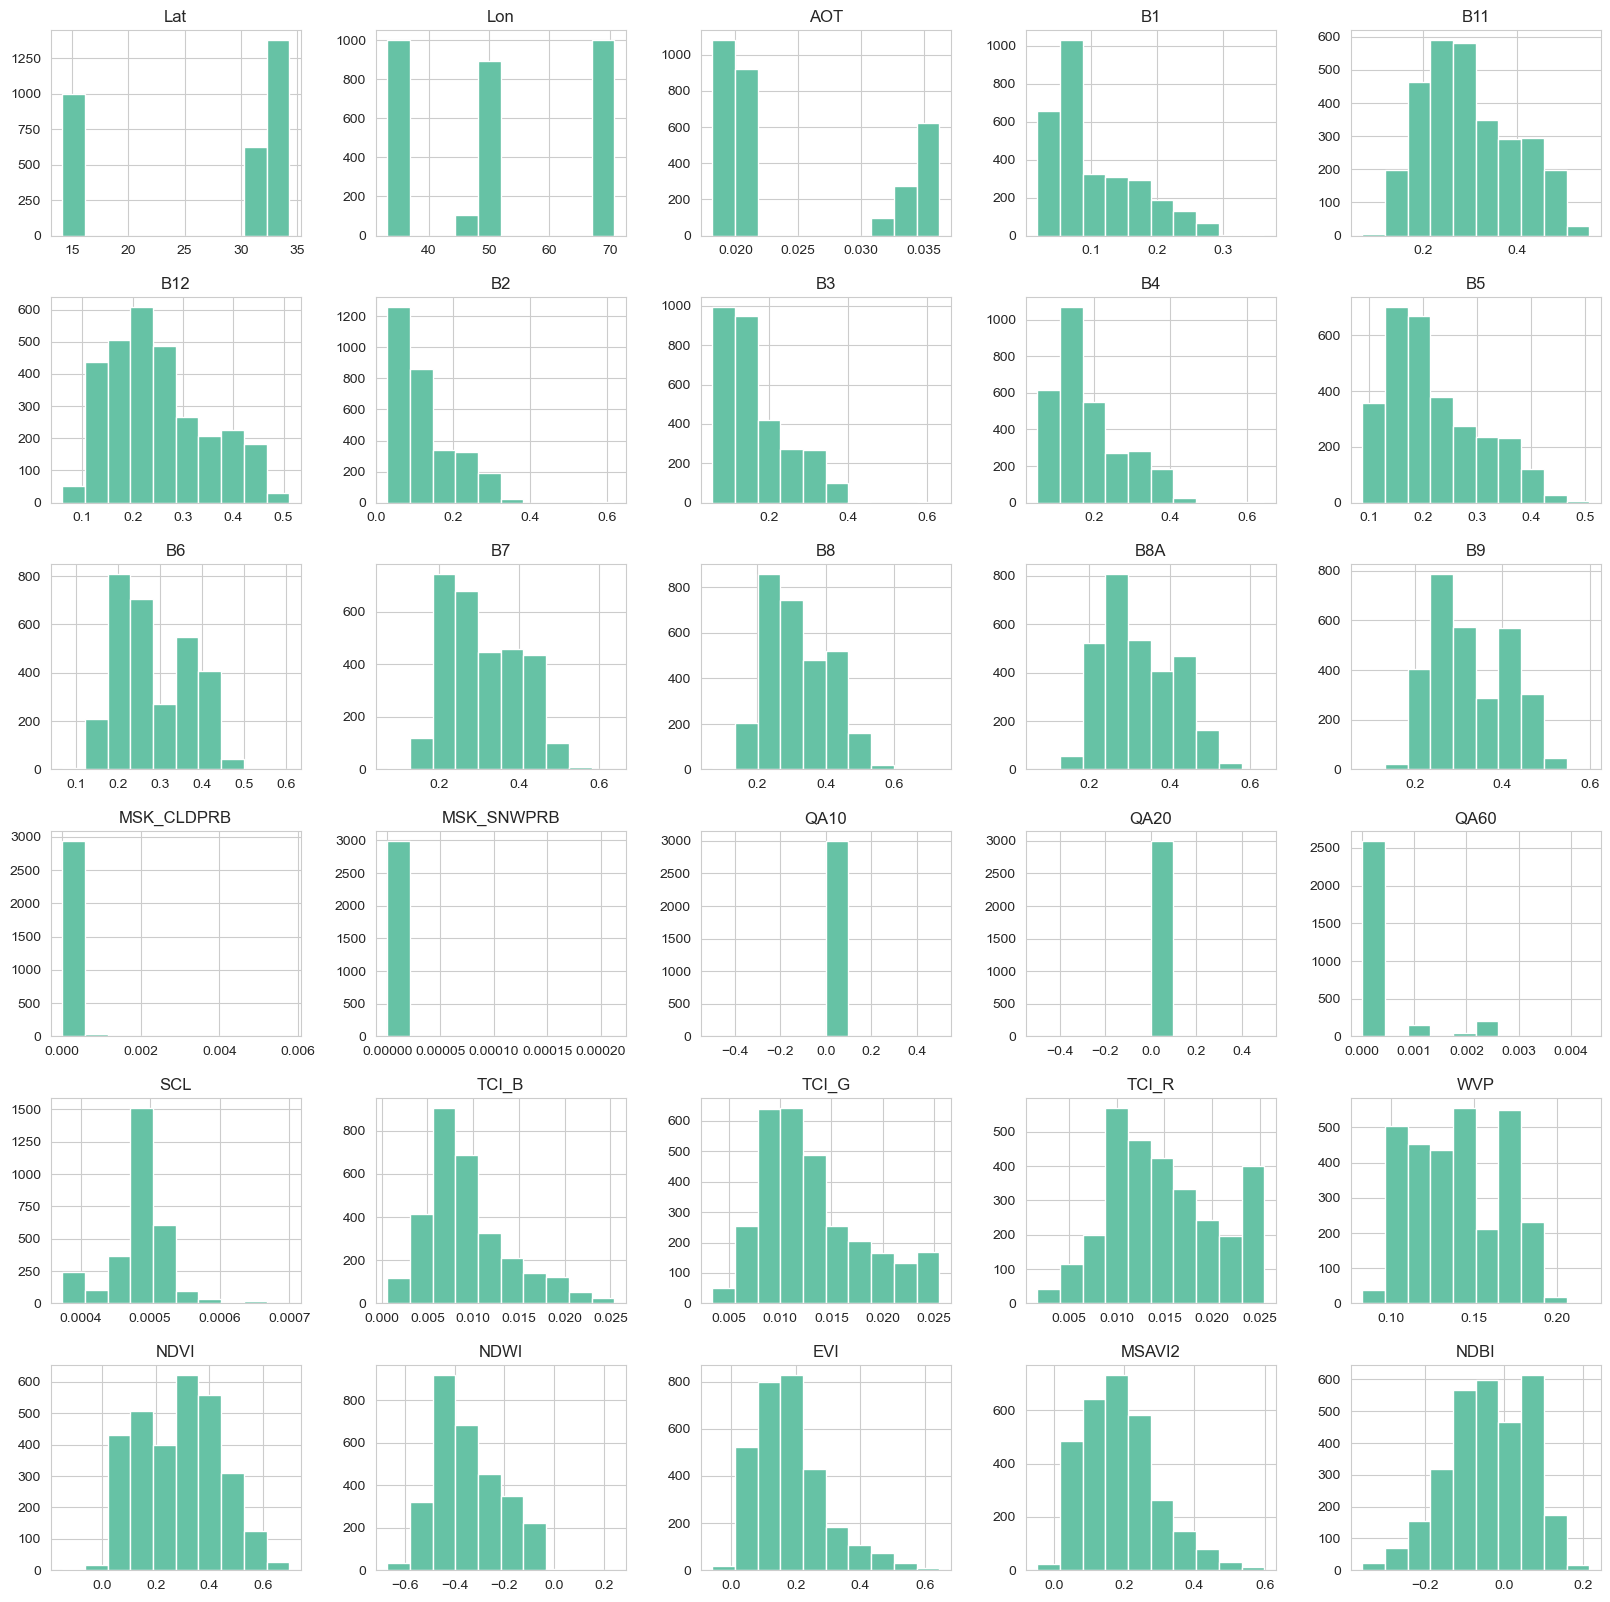

In [25]:
countries_set_indices.hist(figsize=(20, 20))

In [26]:
countries_set_indices.columns

Index(['Lat', 'Lon', 'AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6',
       'B7', 'B8', 'B8A', 'B9', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20',
       'QA60', 'SCL', 'TCI_B', 'TCI_G', 'TCI_R', 'WVP', 'Country', 'NDVI',
       'NDWI', 'EVI', 'MSAVI2', 'NDBI'],
      dtype='object')

In [27]:
single_value_columns = ['MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20','QA60', 'SCL']
countries_set_indices.drop(columns=single_value_columns, inplace=True)

<Axes: >

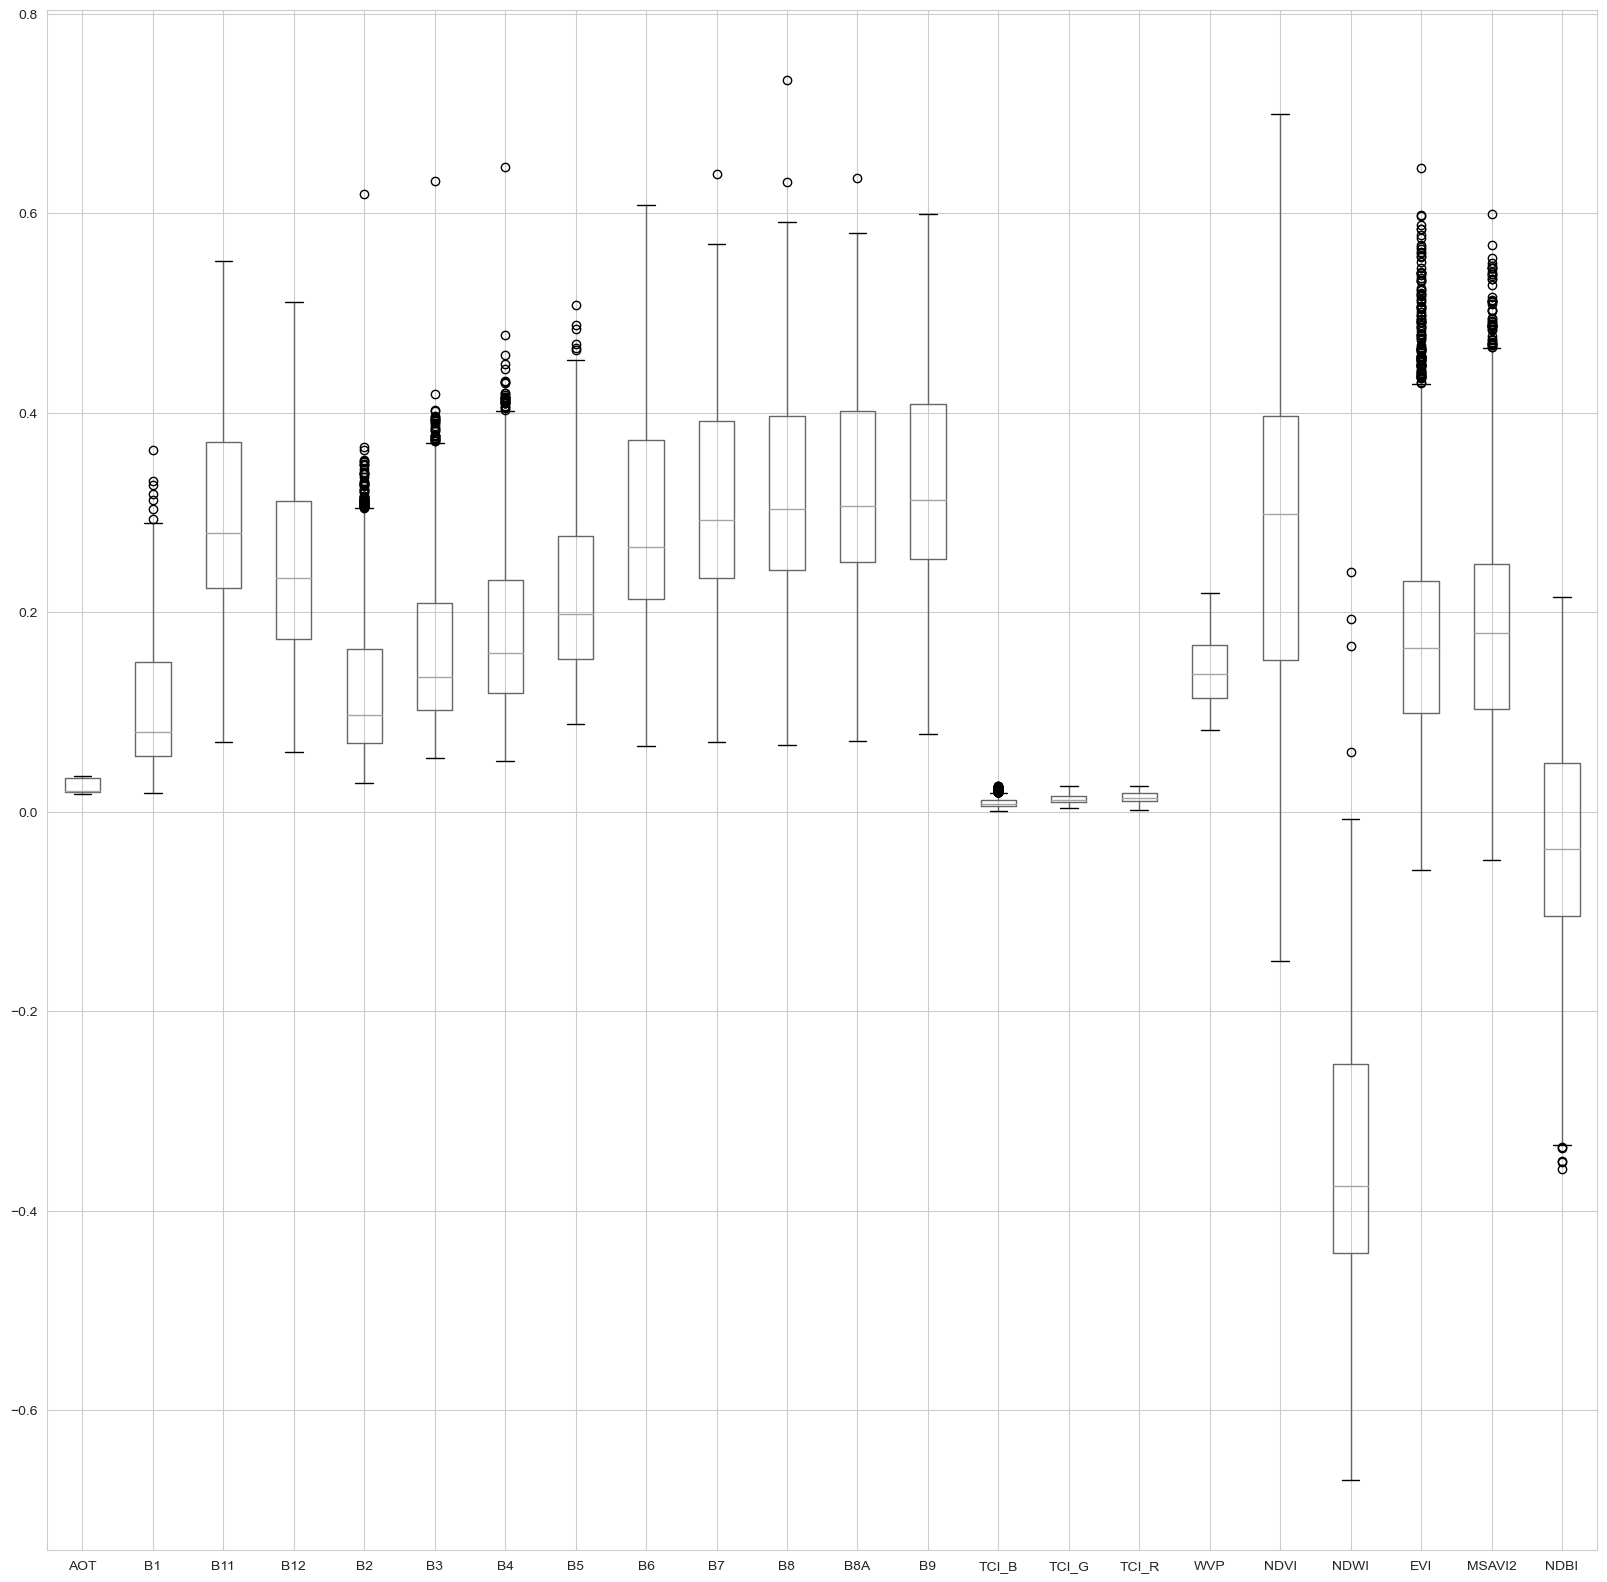

In [29]:
countries_set_indices.drop(columns=['Lat','Lon']).copy().boxplot(figsize=(20, 20))

<Axes: >

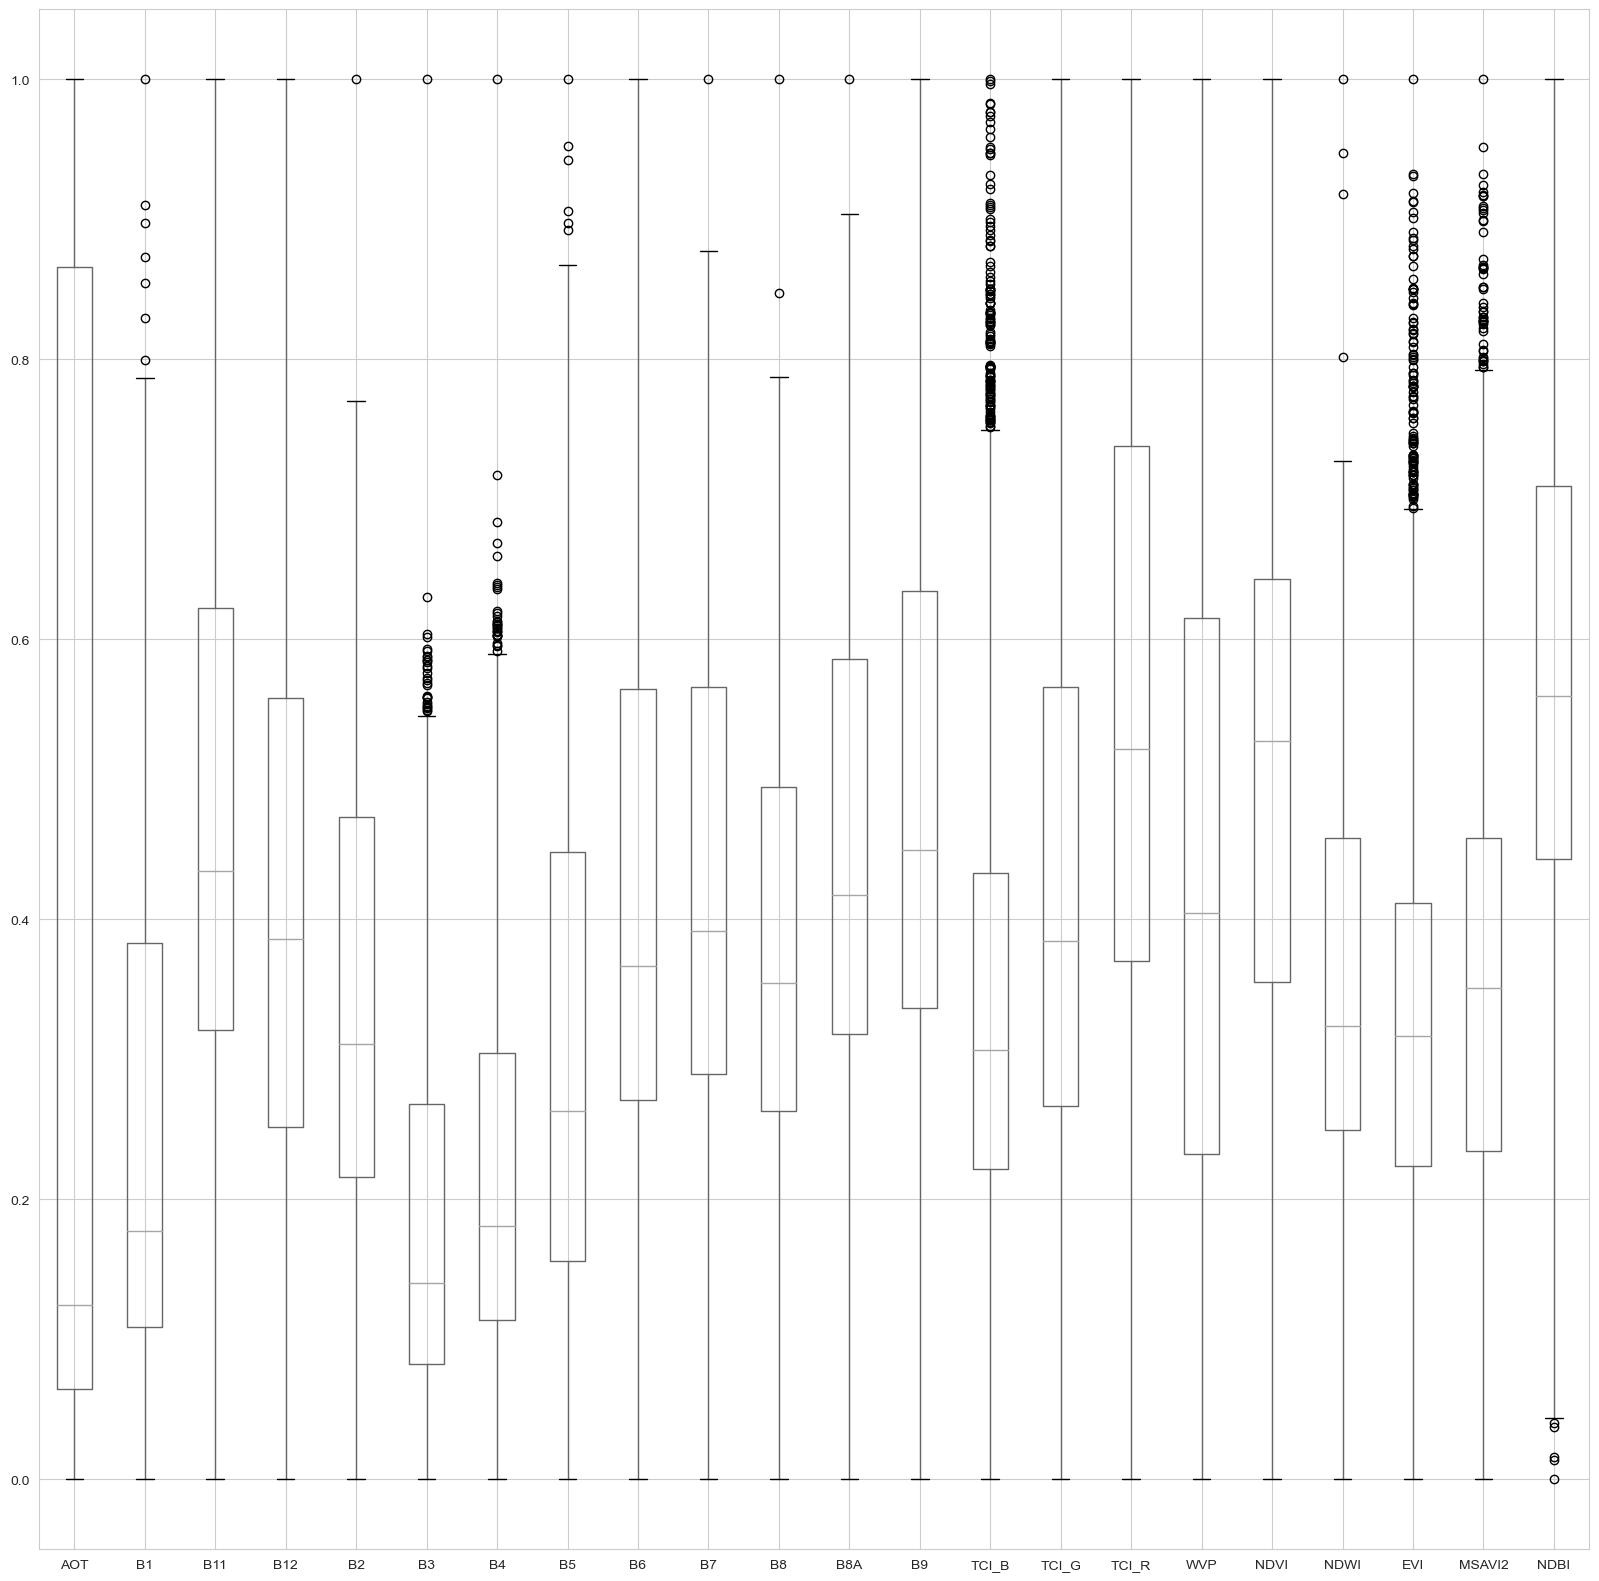

In [53]:
# Scale the data to be between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(countries_set_indices.drop(columns=['Lat','Lon','Country']))
scaled_data = pd.DataFrame(scaled_data, columns=countries_set_indices.drop(columns=['Lat','Lon','Country']).columns, index=countries_set_indices.index)
scaled_data['Lat'] = countries_set_indices['Lat']
scaled_data['Lon'] = countries_set_indices['Lon']
scaled_data['Country'] = countries_set_indices['Country']
scaled_data.copy().drop(columns=['Lat','Lon','Country']).boxplot(figsize=(20, 20))

<Axes: >

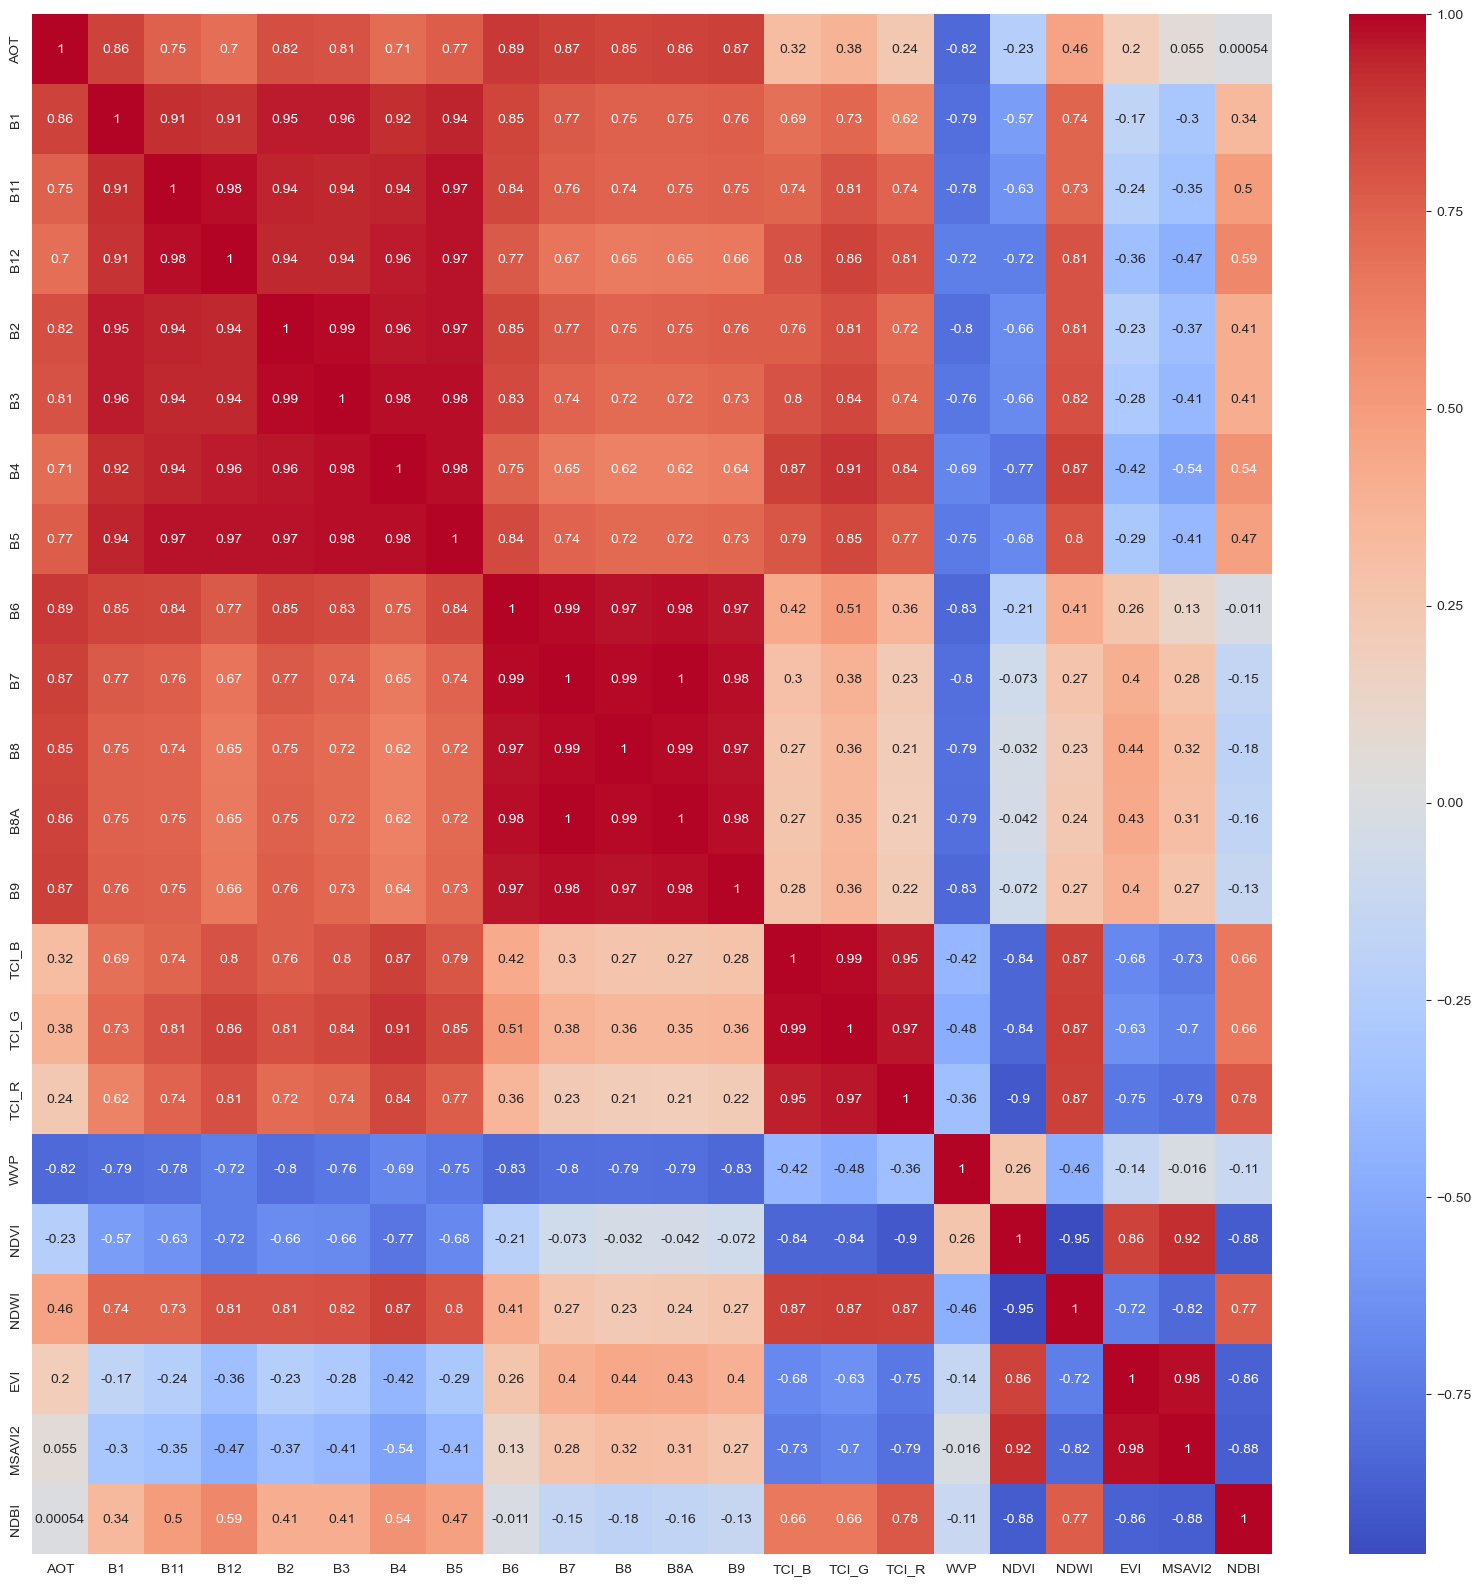

In [50]:
scaled_data_corr = scaled_data.drop(columns=['Lat','Lon','Country']).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(scaled_data_corr, annot=True, cmap='coolwarm')

Under normal circumstances, I would have shaved off some data based on the heatmap of the correlation between some variables. Get highly correlating variables off the dataset. However, I actually think  that all variables(bands) observed are of some relevance to the model. As such I will not be dropping any variables. 
The other step would have been to use weighting on features to tip bias and relevance to certaine features. However, due to the nature of the models I shall be using the weighting will be done by the model itself.

## MODEL BUILDING AND EVALUATION
I will be using the following models to build my model:
1. Random Forest
2. XGBoost
3. LightGBM
4. CatBoost
5. Gradient Boosting

After buiding and evaluating all the models individually, I will then use both a voting classifier and a stacking classifier to get the best model. These ensemble methods take a lot of resources to execute as such there might be some cells that will be marked as ``High Resource Usage``. These cells will be marked with a comment and will be skipped when the notebook is run.

In [83]:
modeling_data = scaled_data.copy()
modeling_data.drop(columns=['Lat','Lon'], inplace=True)
modeling_data = pd.get_dummies(modeling_data, columns=['Country'])
modeling_data.head()

AOT        B1       B11       B12        B2        B3  \
ID                                                                            
ID_CWCD60FGJJYY  0.143749  0.096872  0.289348  0.187794  0.193009  0.063800   
ID_5QV3RGD8E6L6  0.122250  0.169663  0.422346  0.379462  0.276652  0.117214   
ID_OGEL0LA7Y94S  0.124228  0.082344  0.237219  0.174489  0.197118  0.056361   
ID_O4CHBAKY74WZ  0.111912  0.106533  0.386044  0.312715  0.223243  0.082984   
ID_7VVCEG83E9SF  0.129417  0.079099  0.249068  0.147869  0.139163  0.038782   

                       B4        B5        B6        B7  ...     TCI_R  \
ID                                                       ...             
ID_CWCD60FGJJYY  0.079092  0.109280  0.268734  0.292014  ...  0.351587   
ID_5QV3RGD8E6L6  0.144632  0.235957  0.402399  0.431513  ...  0.516899   
ID_OGEL0LA7Y94S  0.064253  0.071965  0.190139  0.205071  ...  0.309499   
ID_O4CHBAKY74WZ  0.116935  0.149178  0.303081  0.352003  ...  0.437050   
ID_7VVCEG83E9SF  0.047868  0.081783  0.234435  0.262148  ...  0.272853   

                      WVP      NDVI      NDWI       EVI    MSAVI2      NDBI  \
ID                                                                            
ID_CWCD60FGJJYY  0.348014  0.714470  0.201420  0.424876  0.478367  0.426408   
ID_5QV3RGD8E6L6  0.437143  0.660624  0.231532  0.445495  0.504080  0.465381   
ID_OGEL0LA7Y94S  0.377326  0.638312  0.290868  0.344437  0.367061  0.534002   
ID_O4CHBAKY74WZ  0.383777  0.646894  0.222319  0.393769  0.451272  0.543178   
ID_7VVCEG83E9SF  0.399286  0.741358  0.192249  0.400258  0.449912  0.472925   

                 Country_Afghanistan  Country_Iran  Country_Sudan  
ID                                                                 
ID_CWCD60FGJJYY                False          True          False  
ID_5QV3RGD8E6L6                False          True          False  
ID_OGEL0LA7Y94S                False          True          False  
ID_O4CHBAKY74WZ                False          True          False  
ID_7VVCEG83E9SF                False          True          False  

[5 rows x 25 columns]

In [84]:
modeling_train = modeling_data.loc[train_data.index]
modeling_test = modeling_data.loc[test_data.index]

modeling_target = target.copy()
print(modeling_train.shape, modeling_test.shape, modeling_target.shape)

(1500, 25) (1500, 25) (1500,)


### Importing Libraries

In [85]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [86]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(modeling_train, modeling_target, test_size=0.2, random_state=42)

### Function Definitions
These functions are to be used for efficiency and to avoid repetition of code. The functions are as follows:
1. ```cross_val``` - This function is used to perform cross validation on the model. It takes in the model, the training data and the training labels. It then performs cross validation and returns the mean accuracy score.
2. ```evaluate``` - This function is used to evaluate the model. It takes in the model, the test data and the test labels. It then returns the classification report, accuracy, Mean Absolute Error, Mean Squared Error, Root Mean Squared Error and R2 Score.
3. ```tune_model``` - This function is used to tune the model. It takes in the model, the training data and the training labels. It then performs a grid or random search on the model and returns the best parameters.

In [87]:
## Cross Validation
def cross_val(model, X_train, y_train, cv=5, scoring='accuracy'):
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    return scores

## Model Evaluation
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('Accuracy: ', model.score(X_test, y_test))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('R2 Score: ', r2_score(y_test, y_pred))

## Model Tuning
def tune_model(model, params, X_train, y_train, cv=5, scoring='accuracy', search_type='grid'):
    if search_type == 'grid':
        search = GridSearchCV(model, params, cv=cv, scoring=scoring)
    elif search_type == 'random':
        search = RandomizedSearchCV(model, params, cv=cv, scoring=scoring)
    search.fit(X_train, y_train)
    return search.best_params_

#### 1. Logistic Regression
This is a simple model that is used to classify data into two classes. It is a linear model that uses a logistic function to predict the probability of an observation belonging to a certain class. I am using this model as a baseline model to compare the other models to.

In [123]:
## Logistic Regression
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 1000, 2500, 5000]
}

lr_model = LogisticRegression()
lr_best_params = tune_model(lr_model, lr_params, X_train, y_train, search_type='random')
lr_best_params

{'solver': 'saga', 'penalty': 'l2', 'max_iter': 2500, 'C': 100}

#### 2. All the other models

In [124]:
lr_best_param_model = LogisticRegression(**lr_best_params)
lr_best_param_model.fit(X_train, y_train)
cross_val(lr_best_param_model, X_train, y_train)
evaluate(lr_best_param_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       134
           1       0.83      0.77      0.80       166

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300

Accuracy:  0.7866666666666666
MAE:  0.21333333333333335
MSE:  0.21333333333333335
RMSE:  0.46188021535170065
R2 Score:  0.1368458910267939


In [90]:
## Gradient Boosting Classifier
gbm_params = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'subsample': [0.5, 0.75, 1],
}

gbm_model = GradientBoostingClassifier()
gbm_best_params = tune_model(gbm_model, gbm_params, X_train, y_train, search_type='random')
gbm_best_params

{'subsample': 0.75, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.5}

In [91]:
gbm_best_param_model = GradientBoostingClassifier(**gbm_best_params)
gbm_best_param_model.fit(X_train, y_train)
cross_val(gbm_best_param_model, X_train, y_train)
evaluate(gbm_best_param_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       134
           1       0.89      0.92      0.91       166

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300

Accuracy:  0.8933333333333333
MAE:  0.10666666666666667
MSE:  0.10666666666666667
RMSE:  0.32659863237109044
R2 Score:  0.5684229455133969


In [92]:
## Random Forest Classifier
rf_params = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [3, 5, 7, 9],
}

rf_model = RandomForestClassifier()
rf_best_params = tune_model(rf_model, rf_params, X_train, y_train, search_type='random')
rf_best_params

{'n_estimators': 250, 'max_depth': 9}

In [93]:
rf_best_param_model = RandomForestClassifier(**rf_best_params)
rf_best_param_model.fit(X_train, y_train)
cross_val(rf_best_param_model, X_train, y_train)
evaluate(rf_best_param_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       134
           1       0.86      0.92      0.89       166

    accuracy                           0.87       300
   macro avg       0.88      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300

Accuracy:  0.8733333333333333
MAE:  0.12666666666666668
MSE:  0.12666666666666668
RMSE:  0.3559026084010437
R2 Score:  0.4875022477971589


In [94]:
## XGBoost Classifier
xgb_params = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'subsample': [0.5, 0.75, 1],
}

xgb_model = XGBClassifier()
xgb_best_params = tune_model(xgb_model, xgb_params, X_train, y_train, search_type='random')
xgb_best_params

{'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.01}

In [95]:
xgb_best_param_model = XGBClassifier(**xgb_best_params)
xgb_best_param_model.fit(X_train, y_train)
cross_val(xgb_best_param_model, X_train, y_train)
evaluate(xgb_best_param_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       134
           1       0.90      0.93      0.92       166

    accuracy                           0.91       300
   macro avg       0.91      0.90      0.91       300
weighted avg       0.91      0.91      0.91       300

Accuracy:  0.9066666666666666
MAE:  0.09333333333333334
MSE:  0.09333333333333334
RMSE:  0.30550504633038933
R2 Score:  0.6223700773242222


In [96]:
# XGBoost Random Forest Classifier
xgbrf_params = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'subsample': [0.5, 0.75, 1],
}

xgbrf_model = XGBRFClassifier()
xgbrf_best_params = tune_model(xgbrf_model, xgbrf_params, X_train, y_train, search_type='random')
xgbrf_best_params

{'subsample': 0.75, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.01}

In [97]:
xgbrf_best_param_model = XGBRFClassifier(**xgbrf_best_params)
xgbrf_best_param_model.fit(X_train, y_train)
cross_val(xgbrf_best_param_model, X_train, y_train)
evaluate(xgbrf_best_param_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       134
           1       0.86      0.92      0.89       166

    accuracy                           0.87       300
   macro avg       0.87      0.86      0.87       300
weighted avg       0.87      0.87      0.87       300

Accuracy:  0.87
MAE:  0.13
MSE:  0.13
RMSE:  0.36055512754639896
R2 Score:  0.47401546484445245


In [98]:
# LightGBM Classifier
lgbm_params = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'subsample': [0.5, 0.75, 1],
}

lgbm_model = LGBMClassifier()
lgbm_best_params = tune_model(lgbm_model, lgbm_params, X_train, y_train, search_type='random')
lgbm_best_params

{'subsample': 0.5, 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 1}

In [99]:
lgbm_best_param_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_param_model.fit(X_train, y_train)
cross_val(lgbm_best_param_model, X_train, y_train)
evaluate(lgbm_best_param_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       134
           1       0.90      0.92      0.91       166

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300

Accuracy:  0.9
MAE:  0.1
MSE:  0.1
RMSE:  0.31622776601683794
R2 Score:  0.5953965114188096


In [100]:
# CatBoost Classifier
cat_params = {
    'iterations': [100, 250, 500, 1000],
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'subsample': [0.5, 0.75, 1],
}

cat_model = CatBoostClassifier()
cat_best_params = tune_model(cat_model, cat_params, X_train, y_train, search_type='random')
cat_best_params

0:	learn: 0.6891790	total: 38.8ms	remaining: 38.7s
1:	learn: 0.6839701	total: 53.6ms	remaining: 26.7s
2:	learn: 0.6793245	total: 64.6ms	remaining: 21.5s
3:	learn: 0.6746141	total: 77.3ms	remaining: 19.2s
4:	learn: 0.6700067	total: 90.8ms	remaining: 18.1s
5:	learn: 0.6662181	total: 105ms	remaining: 17.3s
6:	learn: 0.6617711	total: 115ms	remaining: 16.4s
7:	learn: 0.6574994	total: 122ms	remaining: 15.1s
8:	learn: 0.6531700	total: 128ms	remaining: 14.1s
9:	learn: 0.6489993	total: 134ms	remaining: 13.3s
10:	learn: 0.6448831	total: 140ms	remaining: 12.6s
11:	learn: 0.6411816	total: 147ms	remaining: 12.1s
12:	learn: 0.6372651	total: 152ms	remaining: 11.5s
13:	learn: 0.6337331	total: 156ms	remaining: 11s
14:	learn: 0.6295300	total: 161ms	remaining: 10.6s
15:	learn: 0.6263831	total: 165ms	remaining: 10.1s
16:	learn: 0.6221319	total: 170ms	remaining: 9.81s
17:	learn: 0.6188328	total: 174ms	remaining: 9.51s
18:	learn: 0.6161866	total: 180ms	remaining: 9.32s
19:	learn: 0.6124288	total: 186ms	rema

{'subsample': 0.5, 'learning_rate': 0.1, 'iterations': 100, 'depth': 9}

In [102]:
cat_best_param_model = CatBoostClassifier(**cat_best_params)
cat_best_param_model.fit(X_train, y_train)
cross_val(cat_best_param_model, X_train, y_train)
evaluate(cat_best_param_model, X_test, y_test)

0:	learn: 0.6409284	total: 109ms	remaining: 1m 48s
1:	learn: 0.5930120	total: 182ms	remaining: 1m 30s
2:	learn: 0.5506829	total: 225ms	remaining: 1m 14s
3:	learn: 0.5182090	total: 263ms	remaining: 1m 5s
4:	learn: 0.4929802	total: 303ms	remaining: 1m
5:	learn: 0.4660325	total: 342ms	remaining: 56.7s
6:	learn: 0.4458478	total: 401ms	remaining: 57s
7:	learn: 0.4293992	total: 447ms	remaining: 55.5s
8:	learn: 0.4159981	total: 502ms	remaining: 55.3s
9:	learn: 0.4049323	total: 541ms	remaining: 53.5s
10:	learn: 0.3905419	total: 583ms	remaining: 52.4s
11:	learn: 0.3764850	total: 629ms	remaining: 51.8s
12:	learn: 0.3675197	total: 669ms	remaining: 50.8s
13:	learn: 0.3582160	total: 709ms	remaining: 50s
14:	learn: 0.3493746	total: 752ms	remaining: 49.4s
15:	learn: 0.3421758	total: 787ms	remaining: 48.4s
16:	learn: 0.3336238	total: 829ms	remaining: 47.9s
17:	learn: 0.3247862	total: 868ms	remaining: 47.4s
18:	learn: 0.3157922	total: 909ms	remaining: 46.9s
19:	learn: 0.3104581	total: 948ms	remaining: 

#### 3. Voting Classifier

In [103]:
from sklearn.ensemble import VotingClassifier
# voting Classifier
boosting_estimators = [
    ('xgb', xgb_best_param_model),
    ('xgbrf', xgbrf_best_param_model),
    ('lgbm', lgbm_best_param_model),
    ('gbm', gbm_best_param_model),
    ('cat', cat_best_param_model)
]

voting_model = VotingClassifier(boosting_estimators, voting='soft')
voting_model.fit(X_train, y_train)
cross_val(voting_model, X_train, y_train)
evaluate(voting_model, X_test, y_test)

0:	learn: 0.6409284	total: 41.2ms	remaining: 41.2s
1:	learn: 0.5930120	total: 74.5ms	remaining: 37.2s
2:	learn: 0.5506829	total: 116ms	remaining: 38.6s
3:	learn: 0.5182090	total: 161ms	remaining: 40s
4:	learn: 0.4929802	total: 230ms	remaining: 45.8s
5:	learn: 0.4660325	total: 293ms	remaining: 48.6s
6:	learn: 0.4458478	total: 342ms	remaining: 48.6s
7:	learn: 0.4293992	total: 400ms	remaining: 49.6s
8:	learn: 0.4159981	total: 521ms	remaining: 57.3s
9:	learn: 0.4049323	total: 590ms	remaining: 58.4s
10:	learn: 0.3905419	total: 628ms	remaining: 56.4s
11:	learn: 0.3764850	total: 671ms	remaining: 55.2s
12:	learn: 0.3675197	total: 712ms	remaining: 54.1s
13:	learn: 0.3582160	total: 758ms	remaining: 53.4s
14:	learn: 0.3493746	total: 803ms	remaining: 52.8s
15:	learn: 0.3421758	total: 842ms	remaining: 51.8s
16:	learn: 0.3336238	total: 884ms	remaining: 51.1s
17:	learn: 0.3247862	total: 927ms	remaining: 50.6s
18:	learn: 0.3157922	total: 962ms	remaining: 49.7s
19:	learn: 0.3104581	total: 1.01s	remaini

#### 4. Stacking Classifier

In [112]:
# Stacking Classifier
from sklearn.ensemble import StackingClassifier

stacking_estimators = [
  ('xgb', xgb_best_param_model),
  ('xgbrf', xgbrf_best_param_model),
  ('rf', rf_best_param_model),
  ('gbm', gbm_best_param_model),
  ('cat', cat_best_param_model),
  ('lgbm', lgbm_best_param_model),
]

stacking_model = StackingClassifier(estimators=stacking_estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)

0:	learn: 0.6409284	total: 50.2ms	remaining: 50.2s
1:	learn: 0.5930120	total: 84.3ms	remaining: 42.1s
2:	learn: 0.5506829	total: 122ms	remaining: 40.6s
3:	learn: 0.5182090	total: 163ms	remaining: 40.6s
4:	learn: 0.4929802	total: 199ms	remaining: 39.6s
5:	learn: 0.4660325	total: 231ms	remaining: 38.3s
6:	learn: 0.4458478	total: 270ms	remaining: 38.3s
7:	learn: 0.4293992	total: 322ms	remaining: 39.9s
8:	learn: 0.4159981	total: 362ms	remaining: 39.8s
9:	learn: 0.4049323	total: 410ms	remaining: 40.6s
10:	learn: 0.3905419	total: 467ms	remaining: 42s
11:	learn: 0.3764850	total: 513ms	remaining: 42.2s
12:	learn: 0.3675197	total: 558ms	remaining: 42.3s
13:	learn: 0.3582160	total: 601ms	remaining: 42.3s
14:	learn: 0.3493746	total: 639ms	remaining: 42s
15:	learn: 0.3421758	total: 676ms	remaining: 41.6s
16:	learn: 0.3336238	total: 705ms	remaining: 40.8s
17:	learn: 0.3247862	total: 739ms	remaining: 40.3s
18:	learn: 0.3157922	total: 778ms	remaining: 40.2s
19:	learn: 0.3104581	total: 816ms	remaining

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                                random_state=None, ...)),
                               ('rf',
                                RandomForestClassifier(max_depth=9,
                                                       n_estimators=250)),
                               ('gbm',
                                GradientBoostingClassifier(learning_rate=0.5,
                                                           max_depth=9,
                                                           subsample=0.75)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x000002C1F3799ED0>),
                               ('lgbm',
                                LGBMClassifier(learning_rate=1, max_depth=7,
                                               n_estimators=250,
                                               subsample=0.5))],
                   final_estimator=LogisticRegression())

In [113]:
cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='accuracy')
evaluate(stacking_model, X_test, y_test)

0:	learn: 0.6505433	total: 32.5ms	remaining: 32.5s
1:	learn: 0.6006322	total: 63.3ms	remaining: 31.6s
2:	learn: 0.5542416	total: 97.6ms	remaining: 32.4s
3:	learn: 0.5296116	total: 130ms	remaining: 32.3s
4:	learn: 0.5071969	total: 159ms	remaining: 31.6s
5:	learn: 0.4805689	total: 192ms	remaining: 31.8s
6:	learn: 0.4613615	total: 224ms	remaining: 31.8s
7:	learn: 0.4408660	total: 248ms	remaining: 30.8s
8:	learn: 0.4240550	total: 275ms	remaining: 30.3s
9:	learn: 0.4109256	total: 303ms	remaining: 30s
10:	learn: 0.3960544	total: 332ms	remaining: 29.9s
11:	learn: 0.3783229	total: 367ms	remaining: 30.2s
12:	learn: 0.3647629	total: 405ms	remaining: 30.7s
13:	learn: 0.3528872	total: 440ms	remaining: 31s
14:	learn: 0.3428466	total: 471ms	remaining: 31s
15:	learn: 0.3372357	total: 510ms	remaining: 31.4s
16:	learn: 0.3278489	total: 541ms	remaining: 31.3s
17:	learn: 0.3208784	total: 573ms	remaining: 31.2s
18:	learn: 0.3129416	total: 608ms	remaining: 31.4s
19:	learn: 0.3070006	total: 642ms	remaining:

In [114]:
# Stacking stacked model with voting classifier
sv_estimators = [
  ('voting', voting_model),
  ('stacking', stacking_model)
]

sv_model = StackingClassifier(estimators=sv_estimators, final_estimator=LogisticRegression())
sv_model.fit(X_train, y_train)

0:	learn: 0.6409284	total: 42.2ms	remaining: 42.2s
1:	learn: 0.5930120	total: 77ms	remaining: 38.4s
2:	learn: 0.5506829	total: 105ms	remaining: 34.9s
3:	learn: 0.5182090	total: 134ms	remaining: 33.3s
4:	learn: 0.4929802	total: 162ms	remaining: 32.1s
5:	learn: 0.4660325	total: 187ms	remaining: 31.1s
6:	learn: 0.4458478	total: 214ms	remaining: 30.4s
7:	learn: 0.4293992	total: 298ms	remaining: 37s
8:	learn: 0.4159981	total: 341ms	remaining: 37.6s
9:	learn: 0.4049323	total: 371ms	remaining: 36.7s
10:	learn: 0.3905419	total: 397ms	remaining: 35.7s
11:	learn: 0.3764850	total: 425ms	remaining: 35s
12:	learn: 0.3675197	total: 452ms	remaining: 34.3s
13:	learn: 0.3582160	total: 483ms	remaining: 34s
14:	learn: 0.3493746	total: 514ms	remaining: 33.7s
15:	learn: 0.3421758	total: 540ms	remaining: 33.2s
16:	learn: 0.3336238	total: 573ms	remaining: 33.1s
17:	learn: 0.3247862	total: 604ms	remaining: 33s
18:	learn: 0.3157922	total: 639ms	remaining: 33s
19:	learn: 0.3104581	total: 667ms	remaining: 32.7s


KeyboardInterrupt: 

In [ ]:
sv_model.score(X_test, y_test)
evaluate(sv_model, X_test, y_test)

## FINAL MODEL AND SUBMISSION
The final model that I will be using will be a Stacking Classifier. This is because it has the best performance of all the models that I have used. Additionally, it is a combination of all the models that I have used. As such it is the best model to use.

In [115]:
from sklearn.ensemble import StackingClassifier

stacking_estimators = [
  ('xgb', xgb_best_param_model),
  ('xgbrf', xgbrf_best_param_model),
  ('rf', rf_best_param_model),
  ('gbm', gbm_best_param_model),
  ('cat', cat_best_param_model),
  ('lgbm', lgbm_best_param_model),
]

stacking_model_f = StackingClassifier(estimators=stacking_estimators, final_estimator=LogisticRegression())
stacking_model_f.fit(modeling_train, modeling_target)

0:	learn: 0.6308254	total: 20.9ms	remaining: 20.9s
1:	learn: 0.5817127	total: 41.5ms	remaining: 20.7s
2:	learn: 0.5359195	total: 63.9ms	remaining: 21.2s
3:	learn: 0.5074032	total: 87ms	remaining: 21.7s
4:	learn: 0.4823181	total: 109ms	remaining: 21.6s
5:	learn: 0.4603538	total: 131ms	remaining: 21.6s
6:	learn: 0.4406454	total: 154ms	remaining: 21.9s
7:	learn: 0.4194758	total: 177ms	remaining: 21.9s
8:	learn: 0.4038067	total: 201ms	remaining: 22.1s
9:	learn: 0.3922703	total: 222ms	remaining: 22s
10:	learn: 0.3784279	total: 246ms	remaining: 22.1s
11:	learn: 0.3649239	total: 272ms	remaining: 22.4s
12:	learn: 0.3550963	total: 299ms	remaining: 22.7s
13:	learn: 0.3479534	total: 333ms	remaining: 23.5s
14:	learn: 0.3383493	total: 372ms	remaining: 24.4s
15:	learn: 0.3295830	total: 410ms	remaining: 25.2s
16:	learn: 0.3197421	total: 454ms	remaining: 26.3s
17:	learn: 0.3140911	total: 488ms	remaining: 26.6s
18:	learn: 0.3071664	total: 523ms	remaining: 27s
19:	learn: 0.2996911	total: 556ms	remaining

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                                random_state=None, ...)),
                               ('rf',
                                RandomForestClassifier(max_depth=9,
                                                       n_estimators=250)),
                               ('gbm',
                                GradientBoostingClassifier(learning_rate=0.5,
                                                           max_depth=9,
                                                           subsample=0.75)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x000002C1F3799ED0>),
                               ('lgbm',
                                LGBMClassifier(learning_rate=1, max_depth=7,
                                               n_estimators=250,
                                               subsample=0.5))],
                   final_estimator=LogisticRegression())

In [116]:
preds = stacking_model_f.predict(modeling_test)
submission = pd.DataFrame({'ID': modeling_test.index, 'Target': preds})
submission.to_csv('data/submission_v5.csv', index=False)

## CONCLUSION
These are my final remarks about the project.

### Data Acquisition
The data I used was acquired from Google Earth Engine. This is because the data is very large and it would be very difficult to get the data from any other source. Additionally, the data is already processed and ready for use. This makes it very easy to use. However, the process of getting the data is very tedious and time consuming. This is because the data is not stored locally and has to be downloaded from the server. This makes the process very slow.
Overally though, the data is very good and is very useful for the task at hand.

### Indices and Band calculations
The indices I used are some porpular and well backed ones, however, there was much that I left undone as I did not have enough time to do research, find more indices and better band combinations that would have been useful for this level of learning. 

Finally, I am very grateful for the opportunity to participate in this challenge. I have learnt a lot and I hope to continue learning and improving my skills. Thank you.